In [0]:
import numpy as np

moby = open('moby_dick.txt', 'r')
train_data = moby.read()
moby.close()

letters = np.array(list((np.arange(65, 91)).astype(np.uint8).tostring().decode("ascii")))

In [0]:
import re
import matplotlib.pyplot as plt

def generate_random_cipher(letters, n):
    ciphers = []
    for i in range(n):
        ciphers.append(dict(zip(letters, np.random.permutation(letters))))
    return ciphers

def preprocess_text(text):
    text = text.upper()
    regex = re.compile('[^a-zA-Z]')
    text = regex.sub('', text)
    return text

def bigrams_list(letters):
    bigrams = []
    for i in range(len(letters)):
        for j in range(len(letters)):
            bigrams.append(letters[i] + letters[j])

    return bigrams

def create_language_model(text, letters):
    unigrams = dict(zip(letters, np.zeros(len(letters), dtype=int)))
    size = len(text)
    for c in text:
        unigrams[c] += 1

    unigrams_proba = dict(zip(letters, np.zeros(len(letters), dtype=int)))
    for key in unigrams_proba:    
        unigrams_proba[key] = unigrams[key]/size
    
    bigrams_l = bigrams_list(letters)
    bigrams = dict(zip(bigrams_l, np.zeros(len(bigrams_l), dtype=int)))
    for i in range(len(text) - 1):
        bigram = text[i] + text[i+1]
        bigrams[bigram] += 1

    bigrams_proba = dict(zip(bigrams_l, np.zeros(len(bigrams_l), dtype=int)))
    for key, value in bigrams_proba.items():    
        A = key[0]
        B = key[1]
        bigrams_proba[key] = (bigrams[key]+1)/(unigrams[B]+len(letters))

    return unigrams_proba, bigrams_proba

def log_likelihood(message, unigrams, bigrams):
    log_l = np.log(unigrams[message[0]])
    for i in range(1, len(message)):
        log_l += np.log(bigrams[message[i-1] + message[i]])

    return log_l

def encode(cipher, message):
    message = list(message)
    for i in range(len(message)):
        message[i] = cipher[message[i]]

    return ''.join(message)

def decode(cipher, message):
    message = list(message)
    for i in range(len(message)):
        message[i] = list(cipher.keys())[list(cipher.values()).index(message[i])]

    return ''.join(message)

def random_rotation(cipher):
    l = np.arange(65, 91)
    keys_to_rotate = np.array(list((np.random.choice(l, 2, replace=False)).astype(np.uint8).tostring().decode("ascii")))
    keyA = keys_to_rotate[0]
    keyB = keys_to_rotate[1]
    letterA = cipher[keyA]
    letterB = cipher[keyB]
    cipher2 = dict(cipher)
    cipher2[keyA] = letterB
    cipher2[keyB] = letterA

    return cipher2

def generate_offspring(DNA_pool, n):
    new_DNA_pool = list(DNA_pool)

    for parent in DNA_pool:
        for i in range(n):
            new_DNA_pool.append(random_rotation(parent))

    return new_DNA_pool

def decrypt(message, epochs, unigrams, bigrams):
    DNA_pool = generate_random_cipher(letters, 20)

    lls = []
    for i in range(epochs):
        print('epoch ', i+1, end=' ')
        if i > 0:
            DNA_pool = generate_offspring(DNA_pool, 3)
        
        decoded = []
        for cipher in DNA_pool:
            decoded.append(decode(cipher, message))

        scores = []
        for dec_message in decoded:
            scores.append(log_likelihood(dec_message, unigrams, bigrams))

        sorted_scores = np.argsort(scores)[15:]
        DNA_pool = list(np.array(DNA_pool)[sorted_scores])

        print('likelihood: ', sorted(scores)[-1])
        lls.append(sorted(scores)[-1])

    plt.plot(lls)
    plt.show()

    return [x for _, x in sorted(zip(scores, decoded))][-1]

In [0]:
def error_rate(p, y):
    p2 = np.array(list(p))
    y2 = np.array(list(y))

    return np.mean(p2 != y2)

epoch  1 likelihood:  -1617.76726502578
epoch  2 likelihood:  -1573.1040185820757
epoch  3 likelihood:  -1560.579118654528
epoch  4 likelihood:  -1559.2254004510162
epoch  5 likelihood:  -1534.8873779738674
epoch  6 likelihood:  -1481.8347719165379
epoch  7 likelihood:  -1440.3307583397568
epoch  8 likelihood:  -1422.4296651680643
epoch  9 likelihood:  -1422.4296651680643
epoch  10 likelihood:  -1421.5881570619658
epoch  11 likelihood:  -1400.5574402900556
epoch  12 likelihood:  -1396.6402854936205
epoch  13 likelihood:  -1365.8842572250207
epoch  14 likelihood:  -1363.1508988274995
epoch  15 likelihood:  -1354.9212563883925
epoch  16 likelihood:  -1350.9075422531919
epoch  17 likelihood:  -1322.2079444499673
epoch  18 likelihood:  -1322.2079444499673
epoch  19 likelihood:  -1322.0699147046762
epoch  20 likelihood:  -1319.1738226785592
epoch  21 likelihood:  -1319.1738226785592
epoch  22 likelihood:  -1319.1738226785592
epoch  23 likelihood:  -1307.2786473312858
epoch  24 likelihood:  

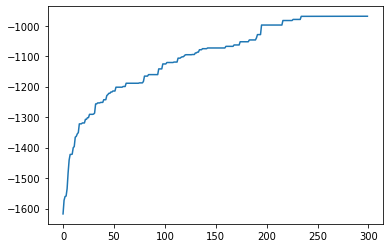

Decrypted message:  ITHENLOUNGEDDOWNTHESTREETANDFOUNDASIEXPECTEDTHATTHEREWASAMEWSINALANEWHICHRUNSDOWNBYONEWALLOFTHEGARDENILENTTHEOSTLERSAHANDINRUBBINGDOWNTHEIRHORSESANDRECEIVEDINEXCHANGETWOPENCEAGLASSOFHALFANDHALFTWOFILLSOFSHAGTOBACCOANDASMUCHINFORMATIONASICOULDDESIREABOUTMISSADLERTOSAYNOTHINGOFHALFADOKENOTHERPEOPLEINTHENEIGHBOURHOODINWHOMIWASNOTINTHELEASTINTERESTEDBUTWHOSEBIOGRAPHIESIWASCOMPELLEDTOLISTENTO
Error rate:  0.002564102564102564


In [151]:
t = preprocess_text(train_data)
unigrams, bigrams = create_language_model(t, letters)

message = preprocess_text('''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
''')

decrypted = decrypt(message, 300, unigrams, bigrams)

print('Decrypted message: ', decrypted)
print('Error rate: ', error_rate(decrypted, message))